<a href="https://colab.research.google.com/github/ESBL01/2025_AI/blob/main/FashionMNIST_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

def evaluate(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return 100 * correct / total


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 272kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.1MB/s]


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

model_cnn = SimpleCNN().to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cnn_acc = []
for epoch in range(10):
    model_cnn.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_cnn(x), y)
        loss.backward()
        optimizer.step()
    acc = evaluate(model_cnn)
    cnn_acc.append(acc)
    print(f"SimpleCNN Epoch {epoch+1}: {acc:.2f}%")

SimpleCNN Epoch 1: 86.67%
SimpleCNN Epoch 2: 88.70%
SimpleCNN Epoch 3: 89.00%
SimpleCNN Epoch 4: 89.43%
SimpleCNN Epoch 5: 89.97%
SimpleCNN Epoch 6: 89.87%
SimpleCNN Epoch 7: 89.48%
SimpleCNN Epoch 8: 89.16%
SimpleCNN Epoch 9: 89.89%
SimpleCNN Epoch 10: 89.68%


In [3]:
from torchvision.models import resnet18

model_resnet = resnet18(weights=None)
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)
model_resnet = model_resnet.to(device)

optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

resnet_acc = []
for epoch in range(10):
    model_resnet.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_resnet(x), y)
        loss.backward()
        optimizer.step()
    acc = evaluate(model_resnet)
    resnet_acc.append(acc)
    print(f"ResNet18 Epoch {epoch+1}: {acc:.2f}%")


ResNet18 Epoch 1: 87.28%
ResNet18 Epoch 2: 90.06%
ResNet18 Epoch 3: 91.40%
ResNet18 Epoch 4: 88.24%
ResNet18 Epoch 5: 86.97%
ResNet18 Epoch 6: 91.70%
ResNet18 Epoch 7: 92.83%
ResNet18 Epoch 8: 92.53%
ResNet18 Epoch 9: 93.19%
ResNet18 Epoch 10: 91.38%


In [4]:
from torchvision.models import efficientnet_b0

model_eff = efficientnet_b0(weights=None)
model_eff.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # 1채널 대응
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 10)
model_eff = model_eff.to(device)

optimizer = optim.Adam(model_eff.parameters(), lr=0.001)

eff_acc = []
for epoch in range(10):
    model_eff.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_eff(x), y)
        loss.backward()
        optimizer.step()
    acc = evaluate(model_eff)
    eff_acc.append(acc)
    print(f"EfficientNet-B0 Epoch {epoch+1}: {acc:.2f}%")


EfficientNet-B0 Epoch 1: 88.01%
EfficientNet-B0 Epoch 2: 89.43%
EfficientNet-B0 Epoch 3: 91.01%
EfficientNet-B0 Epoch 4: 91.31%
EfficientNet-B0 Epoch 5: 91.41%
EfficientNet-B0 Epoch 6: 91.57%
EfficientNet-B0 Epoch 7: 92.87%
EfficientNet-B0 Epoch 8: 92.76%
EfficientNet-B0 Epoch 9: 93.16%
EfficientNet-B0 Epoch 10: 93.61%


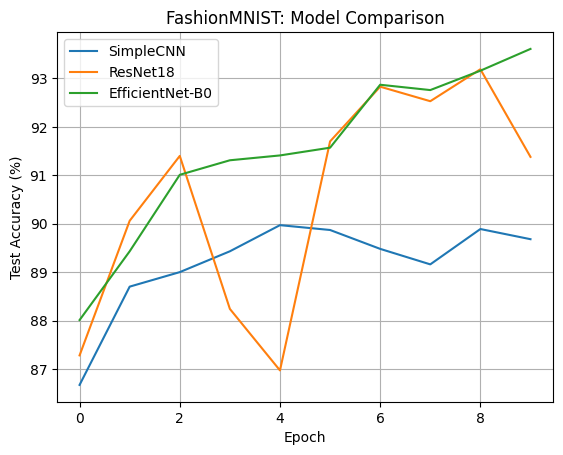

In [5]:
plt.plot(cnn_acc, label='SimpleCNN')
plt.plot(resnet_acc, label='ResNet18')
plt.plot(eff_acc, label='EfficientNet-B0')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("FashionMNIST: Model Comparison")
plt.legend()
plt.grid(True)
plt.show()
